# Continuous Normalizing Flow tutorial: training ODE generative models using maximum likelihood (JAX Version)


This implements a [continuous normalizing flow (CNF)](https://arxiv.org/abs/1806.07366) trained using maximum likelihood.

To compute the likelihood of a sample $x_1$ we use the instantaneous change of variables formula integrated over time that is we have

$$
\begin{pmatrix}
\partial x_t / \partial t \\
\partial \log p(x_t) / \partial t
\end{pmatrix} = 
 \begin{pmatrix}
f(t, x_t)\\
-\text{tr}(\partial f / \partial x_t)
\end{pmatrix} 
$$

which is implemented as a $d+1$ dimensional system. There are two common ways to calculate $\partial \log p(x_t) / \partial t$.
* Exact calcuation of the trace of the Jacobian with essentially $D$ calls of $f$.
* Hutchinson trace estimator either with a normal distribution or Rademacher distribution. Which uses
  $$
    \text{tr}(\partial f / \partial x_t) = \mathbb{E}_{\epsilon} \left [ \epsilon^T [\partial f / \partial x_t] \epsilon \right ]
  $$
  and can be used with a single call to $f$. $\epsilon$ must be distributed such that $\mathbb{E}(\epsilon) = 0$ and $\text{Cov}(\epsilon) = I$. Most often Gaussian or Rademacher distributions are used, and are both implemented here.

As compared to flow matching methods, this requires a calculation of the trace of the Hessian and backpropagation through time so is signficantly slower and more numerically unstable to train.

**Note**: This is a JAX/Flax conversion. JAX provides `jax.jacrev` and `jax.jacfwd` for Jacobian computation, and `jax.vmap` for vectorization.


In [1]:
import os
import sys
import time

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import jax
import jax.numpy as jnp
from jax import random, vmap, jacrev
from jax.scipy.stats import multivariate_normal
import equinox as eqx
# Import diffrax components - ensure fresh imports
from diffrax import diffeqsolve, ODETerm, Euler, SaveAt, AbstractTerm

from jaxcfm.models.models import MLP
from jaxcfm.utils import plot_trajectories, sample_moons

# Verify diffrax imports work correctly
assert hasattr(ODETerm, '__call__'), "ODETerm not properly imported"
print("✓ All imports successful")


✓ All imports successful


In [2]:
def exact_div_fn(u):
    """Accepts a function u:R^D -> R^D and returns divergence function."""
    def div_fn(x, *args):
        # Compute Jacobian and take trace
        J = jacrev(u)(x)
        return jnp.trace(J)
    return div_fn


def div_fn_hutch_trace(u):
    """Hutchinson trace estimator."""
    def div_fn(x, eps):
        # Compute vjp and use Hutchinson estimator
        _, vjp_fn = jax.vjp(u, x)
        return jnp.sum(vjp_fn(eps)[0] * eps)
    return div_fn


class CNFWrapper:
    """Wraps model to a diffrax compatible CNF format.
    Appends an additional dimension representing the change in likelihood
    over time.
    """
    
    def __init__(self, model, params, likelihood_estimator="exact"):
        self.model = model
        self.params = params
        self.likelihood_estimator = likelihood_estimator
        self.div_fn, self.eps_fn = self.get_div_and_eps(likelihood_estimator)
    
    def get_div_and_eps(self, likelihood_estimator):
        if likelihood_estimator == "exact":
            return exact_div_fn, None
        if likelihood_estimator == "hutch_gaussian":
            return div_fn_hutch_trace, lambda key, x: random.normal(key, x.shape)
        if likelihood_estimator == "hutch_rademacher":
            def eps_fn(key, x):
                return (random.randint(key, x.shape, 0, 2).astype(jnp.float32) * 2 - 1.0)
            return div_fn_hutch_trace, eps_fn
        raise NotImplementedError(
            f"likelihood estimator {likelihood_estimator} is not implemented"
        )
    
    def vector_field(self, t, y, args):
        """Vector field for ODE: [dx/dt, dlogp/dt]"""
        key = args if hasattr(jax.random, 'PRNGKeyArray') and isinstance(args, jax.random.PRNGKeyArray) else (args if isinstance(args, type(jax.random.PRNGKey(0))) else None)
        x = y[..., :-1]  # Extract x (without logp dimension)
        logp = y[..., -1:]  # Extract logp
        
        # Model input: concatenate x and t
        t_batch = jnp.full((x.shape[0],), t)
        model_input = jnp.concatenate([x, t_batch[:, None]], axis=-1)
        
        # Compute dx/dt
        dx = self.model.apply(self.params, model_input)
        
        # Compute divergence
        def vecfield(y_single):
            t_single = jnp.array([t])
            model_input_single = jnp.concatenate([y_single, t_single], axis=-1)
            return self.model.apply(self.params, model_input_single)
        
        if self.eps_fn is None:
            # Exact trace
            div = vmap(self.div_fn(vecfield))(x)
        else:
            # Hutchinson trace estimator
            if key is not None:
                key, subkey = random.split(key)
                eps = self.eps_fn(subkey, x)
            else:
                # Fallback: use a dummy key (not ideal but works)
                eps = random.normal(random.PRNGKey(0), x.shape)
            div = vmap(lambda x_i, eps_i: self.div_fn(vecfield)(x_i, eps_i))(x, eps)
        
        # dlogp/dt = -div
        dlogp = -div[:, None]
        
        # Return [dx/dt, dlogp/dt]
        return jnp.concatenate([dx, dlogp], axis=-1)


Training Maximum Likelihood CNF...
Note: This is slower than Flow Matching because it solves ODEs in the loss function.
For faster training, consider using Flow Matching instead (see other notebooks).
200: loss -188.410 time 23.91 (avg: 0.120s/iter)


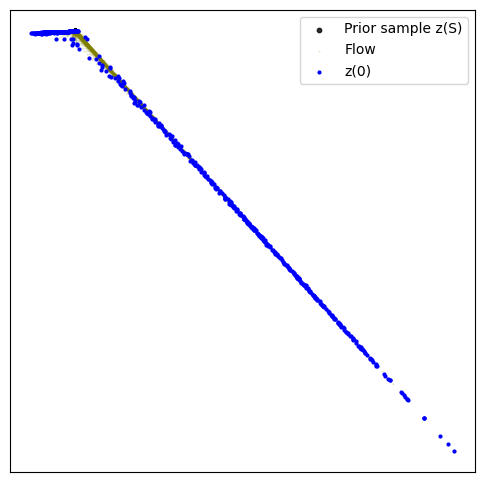

400: loss -191.059 time 22.00 (avg: 0.110s/iter)


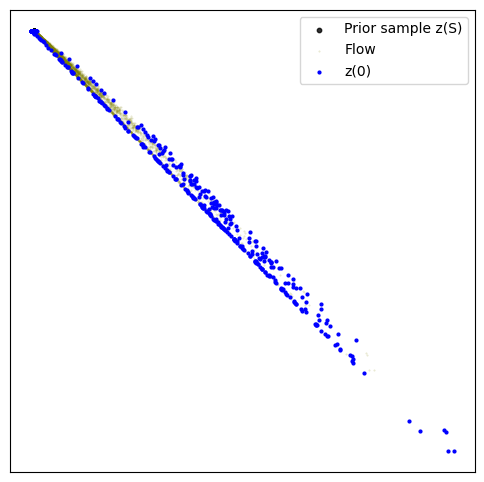

600: loss -187.099 time 23.68 (avg: 0.118s/iter)


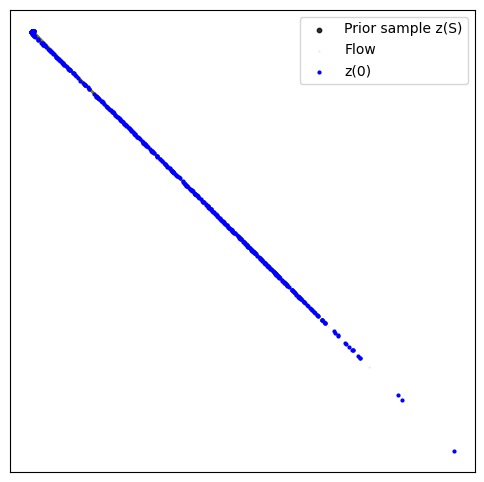

800: loss -189.940 time 21.10 (avg: 0.105s/iter)


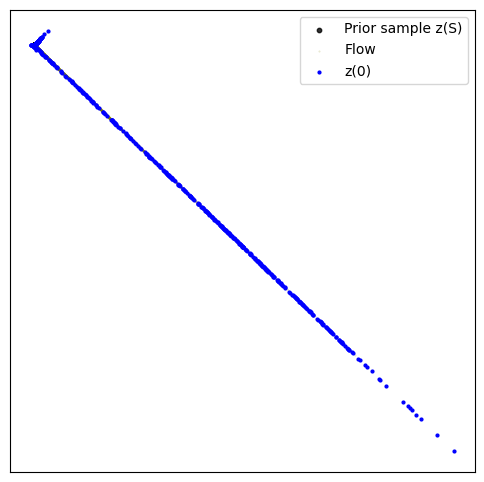

1000: loss -192.273 time 20.65 (avg: 0.103s/iter)


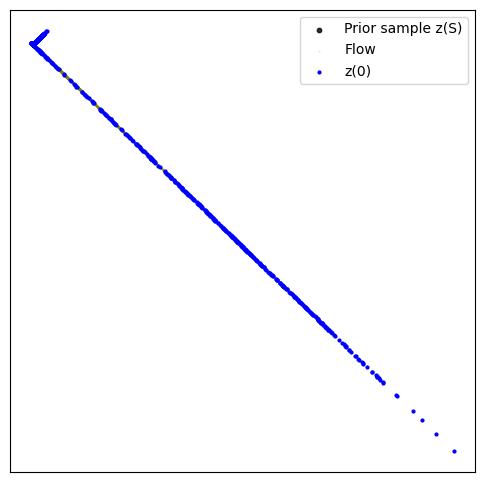

1200: loss -192.736 time 21.13 (avg: 0.106s/iter)


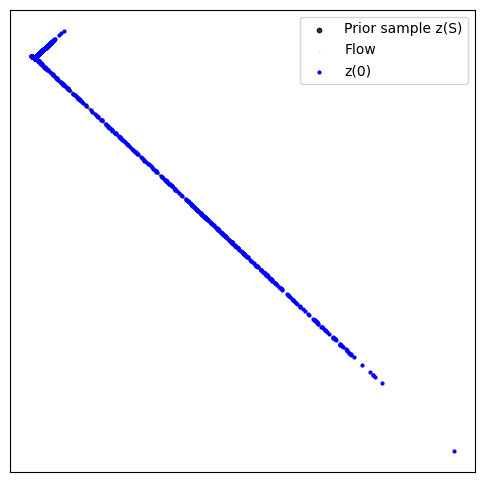

1400: loss -193.281 time 23.38 (avg: 0.117s/iter)


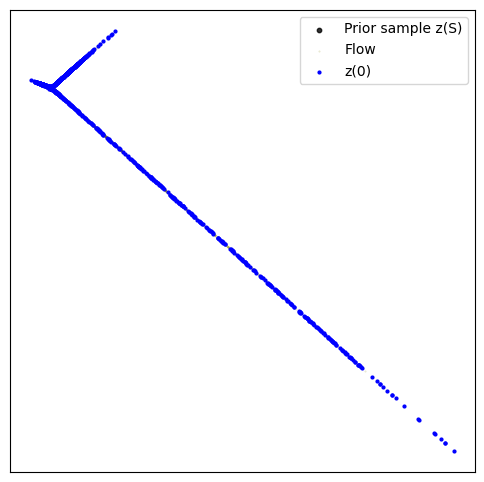

1600: loss -193.152 time 19.99 (avg: 0.100s/iter)


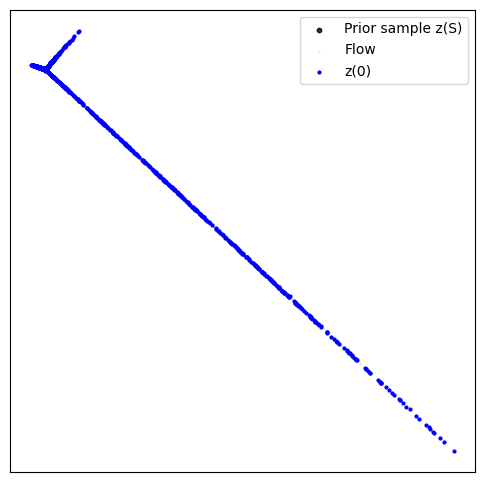

1800: loss -190.782 time 20.50 (avg: 0.102s/iter)


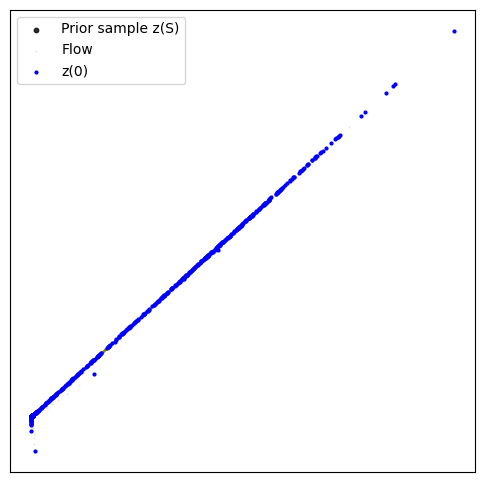

2000: loss -189.429 time 21.27 (avg: 0.106s/iter)


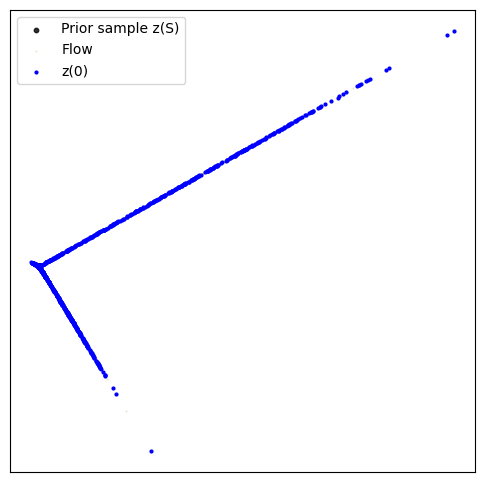

2200: loss -194.081 time 23.56 (avg: 0.118s/iter)


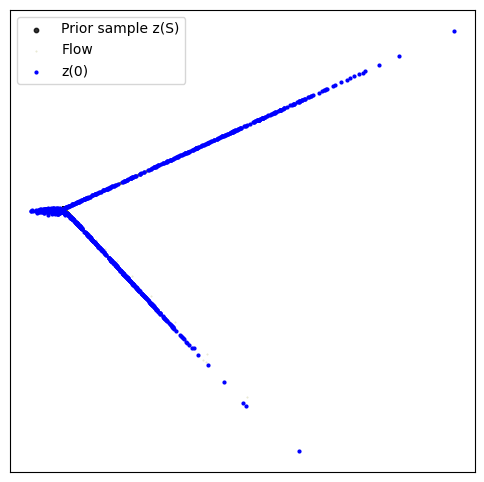

2400: loss -194.288 time 21.13 (avg: 0.106s/iter)


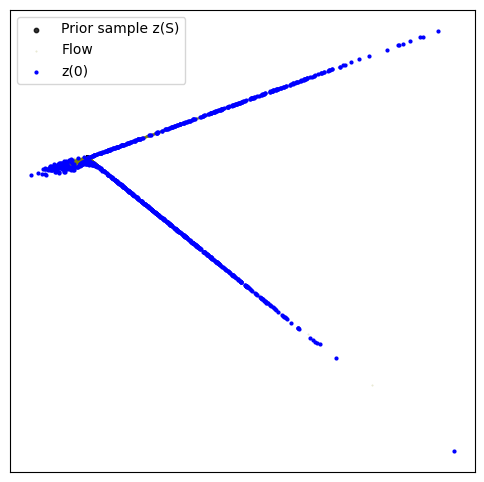

2600: loss -194.514 time 21.16 (avg: 0.106s/iter)


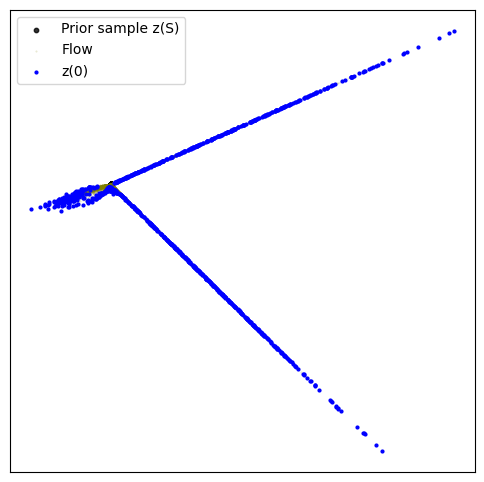

2800: loss -192.494 time 23.64 (avg: 0.118s/iter)


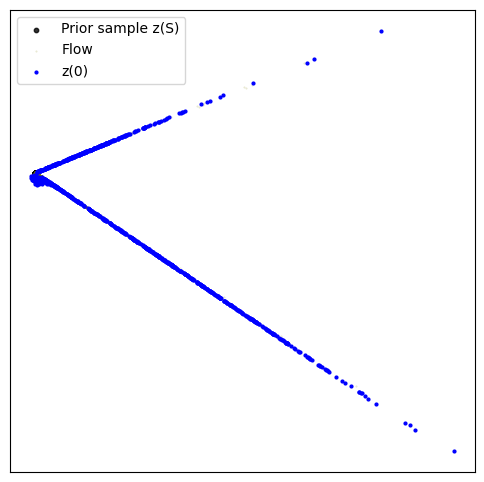

3000: loss -194.648 time 21.14 (avg: 0.106s/iter)


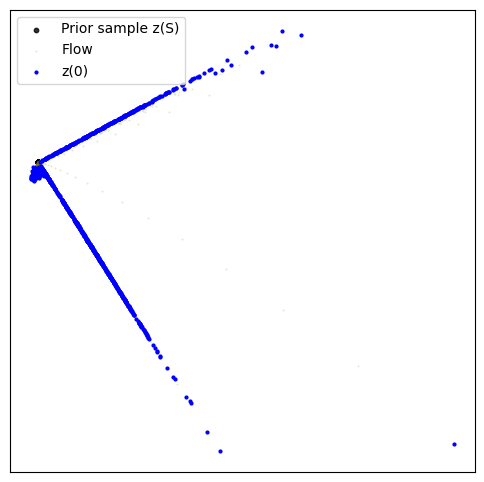

3200: loss -194.886 time 21.07 (avg: 0.105s/iter)


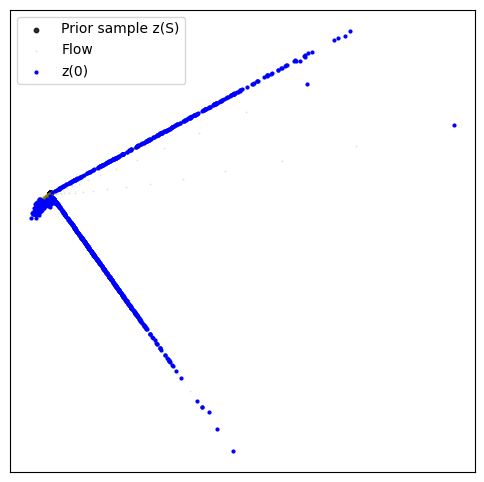

3400: loss -195.100 time 21.23 (avg: 0.106s/iter)


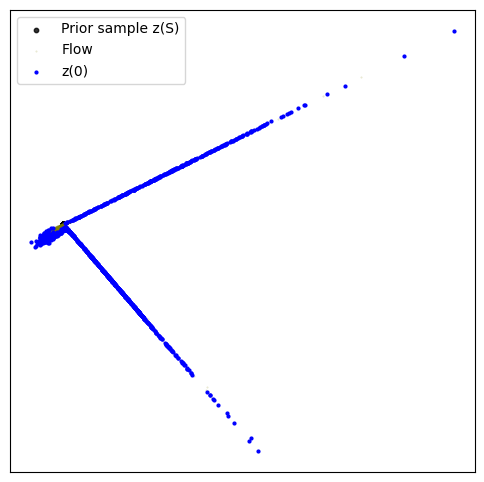

3600: loss -195.333 time 23.64 (avg: 0.118s/iter)


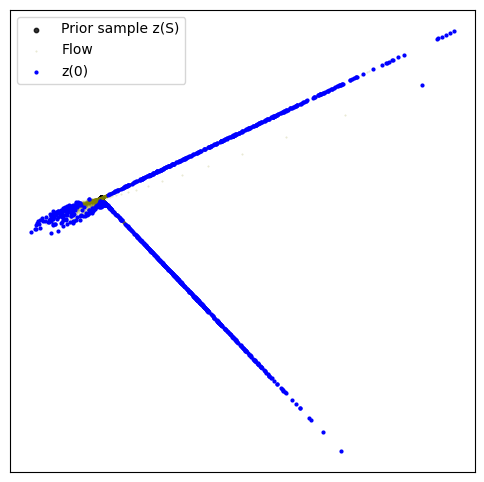

3800: loss -195.167 time 21.15 (avg: 0.106s/iter)


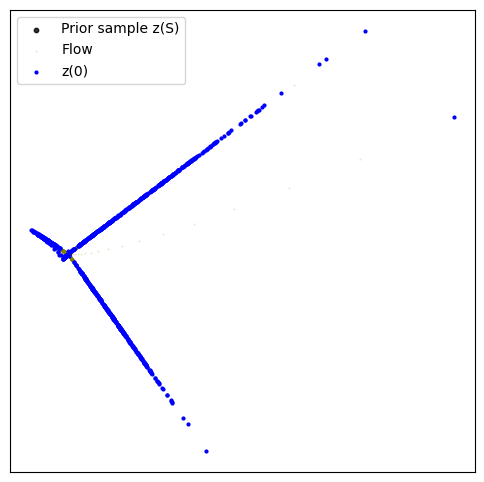

4000: loss -195.376 time 20.88 (avg: 0.104s/iter)


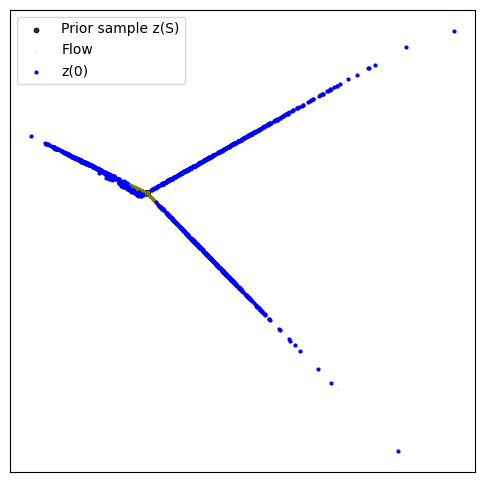

4200: loss -195.515 time 21.24 (avg: 0.106s/iter)


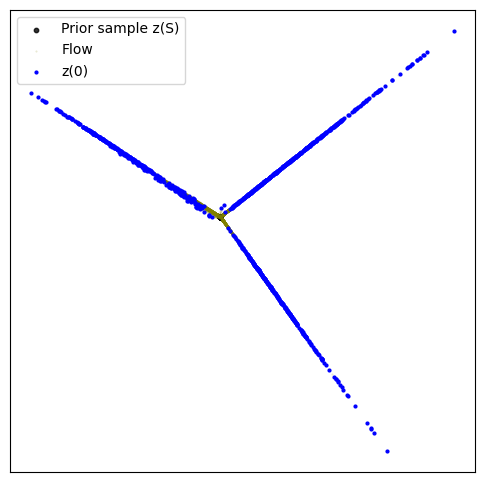

4400: loss -195.216 time 23.63 (avg: 0.118s/iter)


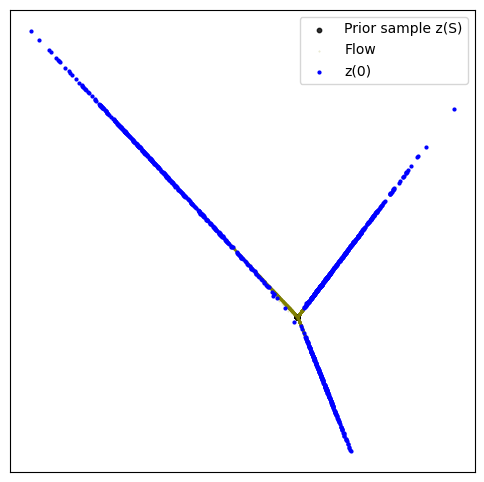

4600: loss -191.593 time 21.15 (avg: 0.106s/iter)


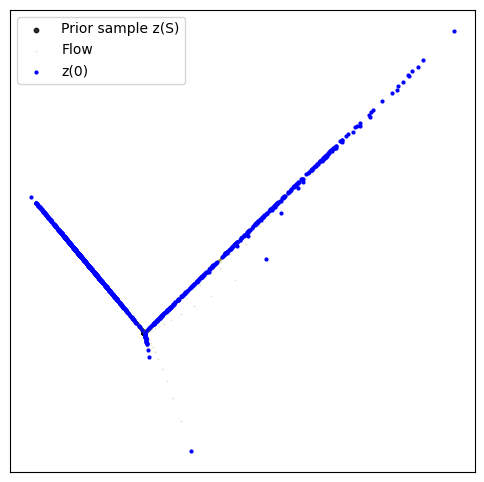

4800: loss -188.620 time 20.88 (avg: 0.104s/iter)


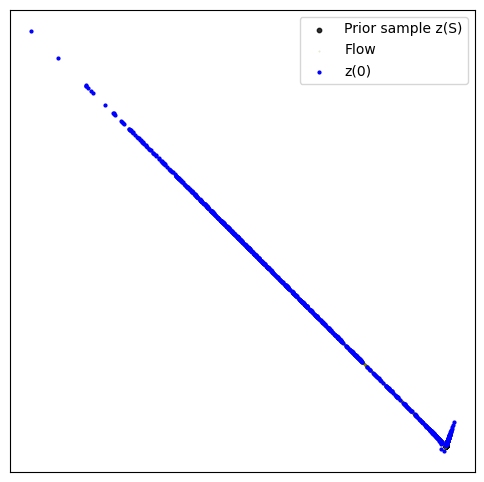

5000: loss -192.852 time 22.46 (avg: 0.112s/iter)


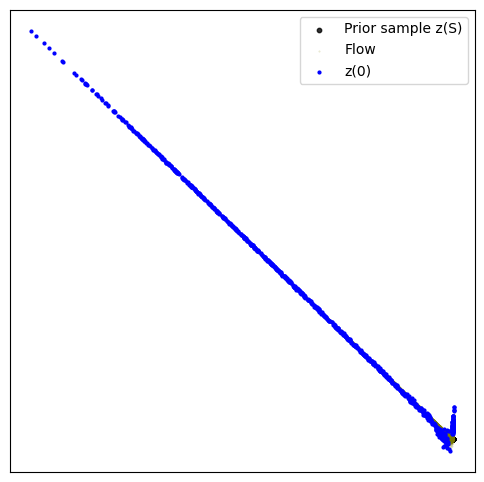

5200: loss -194.185 time 25.21 (avg: 0.126s/iter)


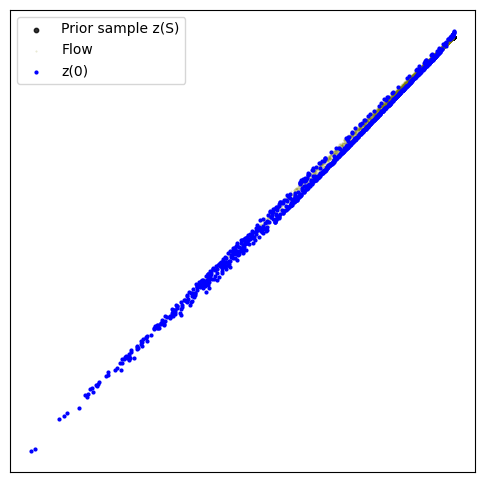

5400: loss -193.636 time 21.94 (avg: 0.110s/iter)


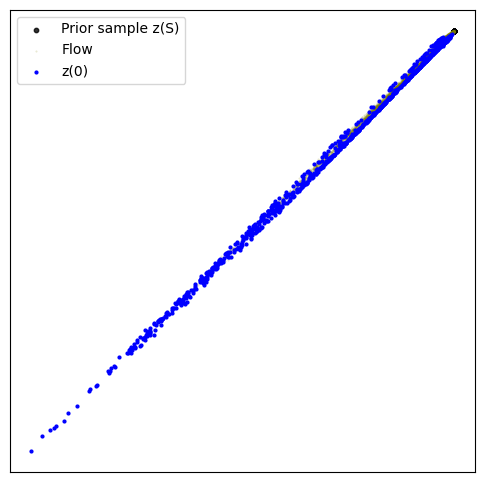

5600: loss -194.035 time 22.17 (avg: 0.111s/iter)


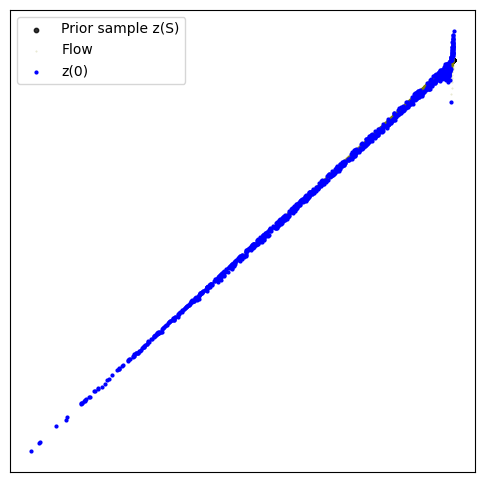

5800: loss -194.587 time 23.18 (avg: 0.116s/iter)


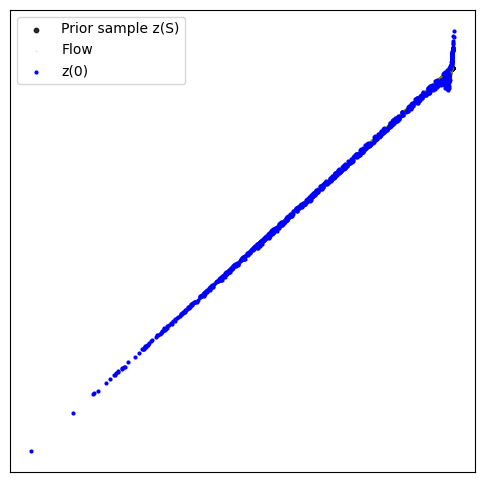

6000: loss -195.256 time 21.67 (avg: 0.108s/iter)


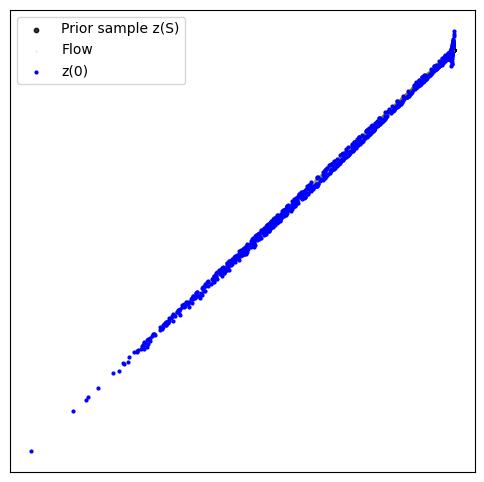

6200: loss -195.141 time 19.80 (avg: 0.099s/iter)


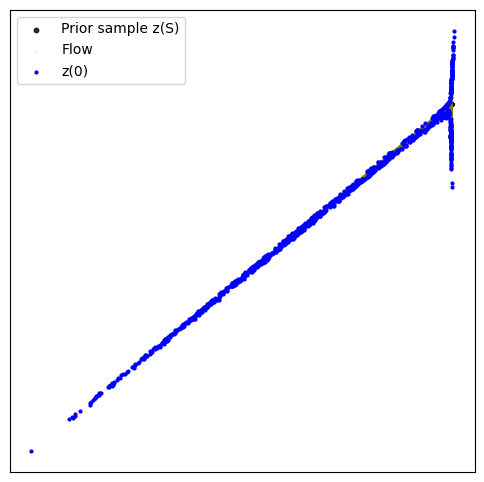

6400: loss -195.641 time 23.19 (avg: 0.116s/iter)


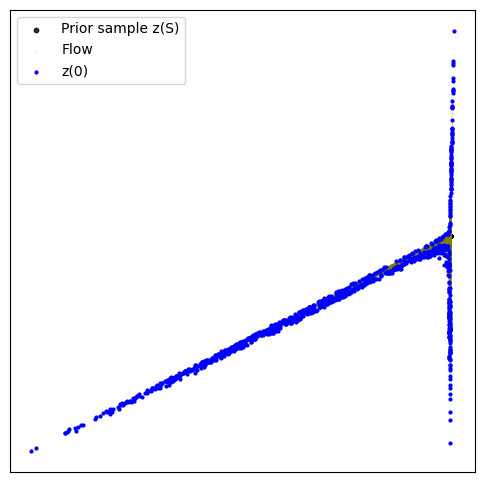

6600: loss -190.721 time 19.11 (avg: 0.096s/iter)


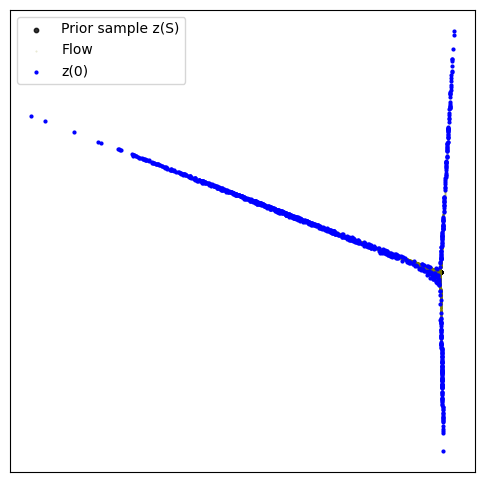

6800: loss -191.372 time 22.61 (avg: 0.113s/iter)


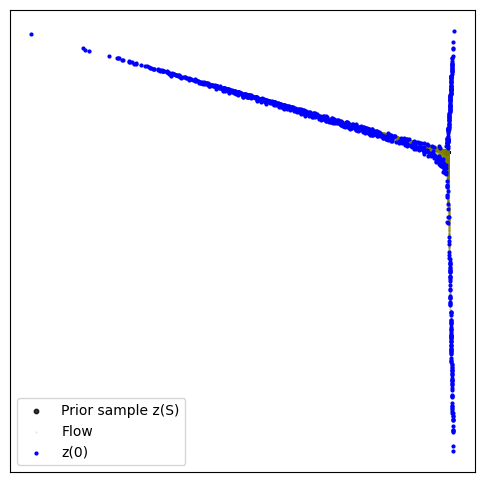

7000: loss -196.287 time 20.95 (avg: 0.105s/iter)


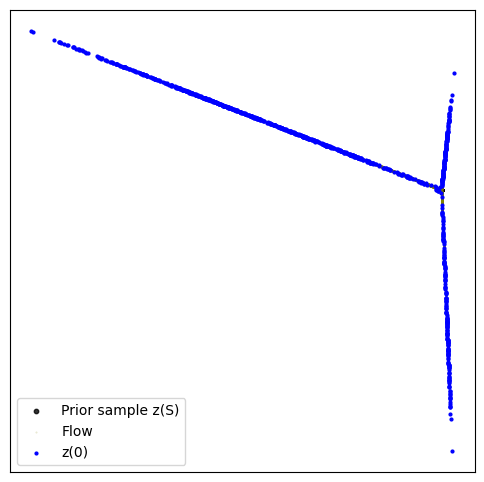

7200: loss -194.971 time 20.82 (avg: 0.104s/iter)


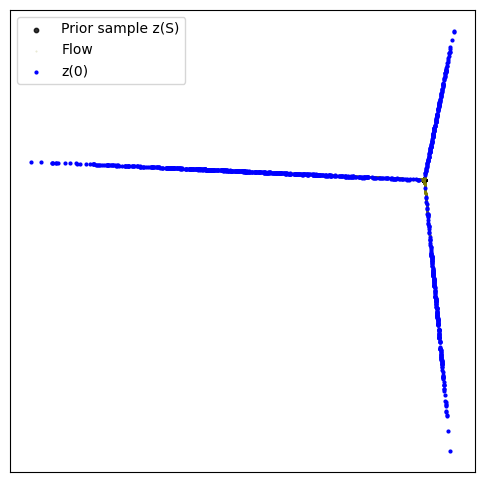

7400: loss -196.784 time 23.94 (avg: 0.120s/iter)


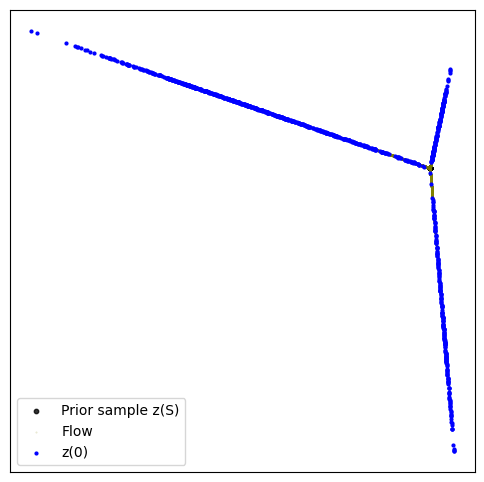

7600: loss -194.151 time 21.32 (avg: 0.107s/iter)


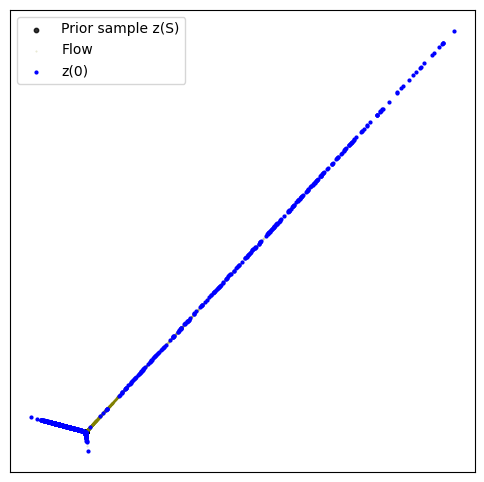

7800: loss -197.433 time 21.17 (avg: 0.106s/iter)


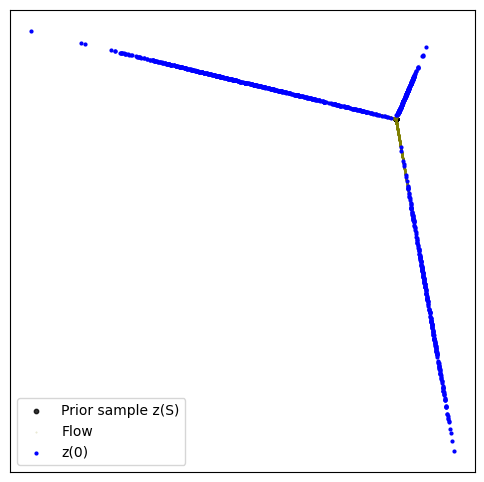

8000: loss -196.639 time 21.04 (avg: 0.105s/iter)


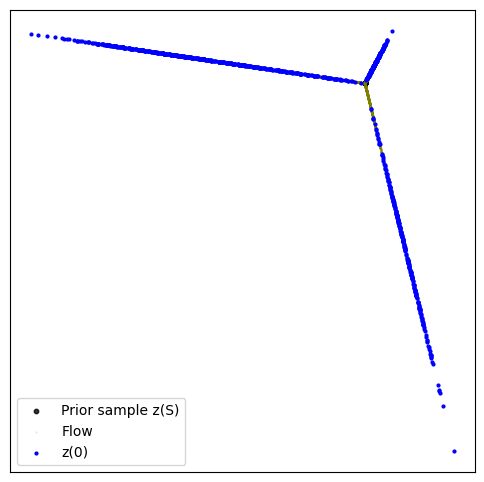

8200: loss -197.515 time 23.27 (avg: 0.116s/iter)


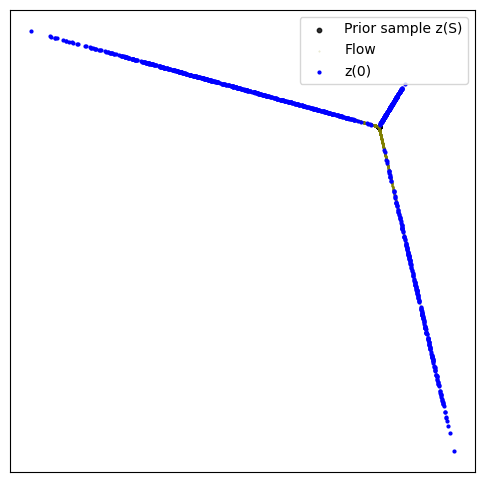

8400: loss -197.750 time 21.26 (avg: 0.106s/iter)


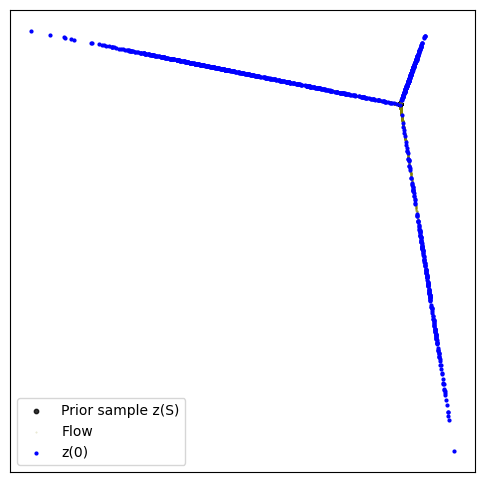

8600: loss -198.874 time 21.34 (avg: 0.107s/iter)


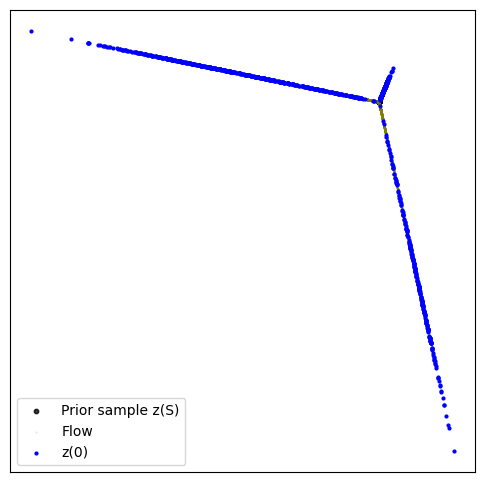

8800: loss -199.373 time 21.52 (avg: 0.108s/iter)


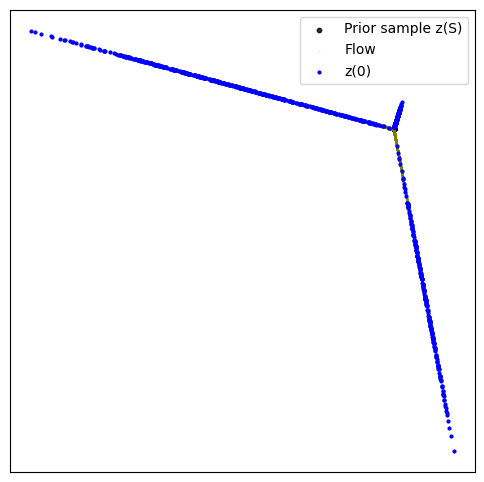

9000: loss -199.627 time 23.93 (avg: 0.120s/iter)


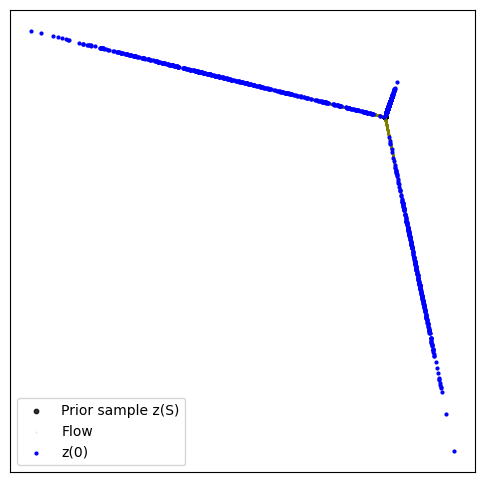

9200: loss -201.494 time 21.25 (avg: 0.106s/iter)


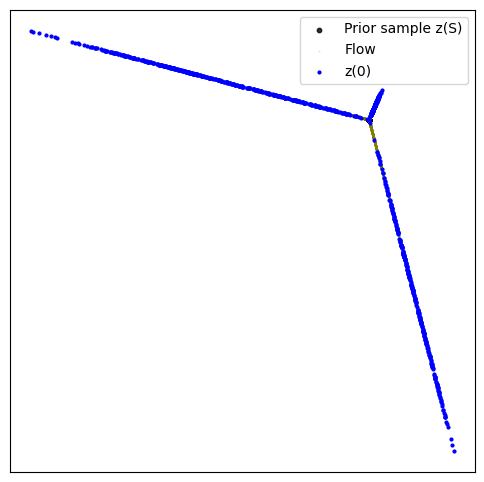

9400: loss -202.354 time 21.29 (avg: 0.106s/iter)


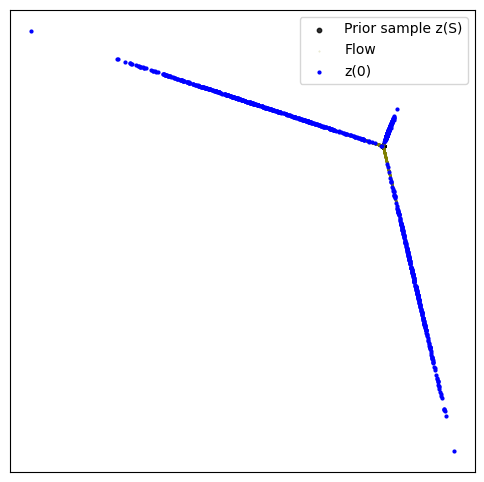

9600: loss -198.039 time 23.65 (avg: 0.118s/iter)


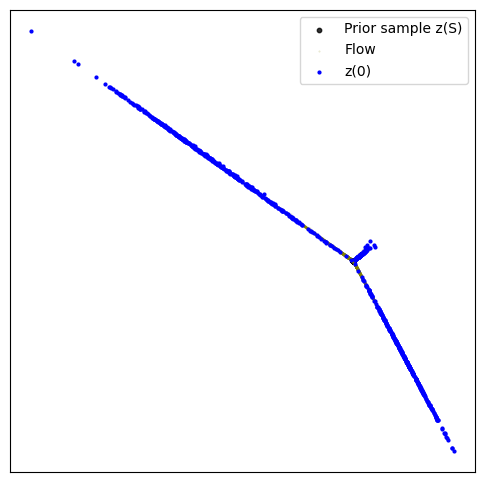

9800: loss -202.696 time 21.29 (avg: 0.106s/iter)


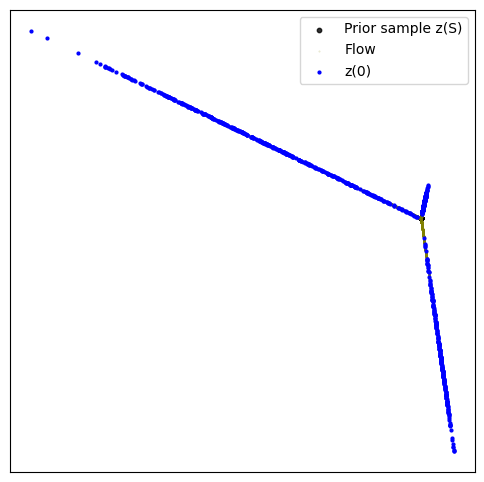

10000: loss -195.974 time 21.21 (avg: 0.106s/iter)


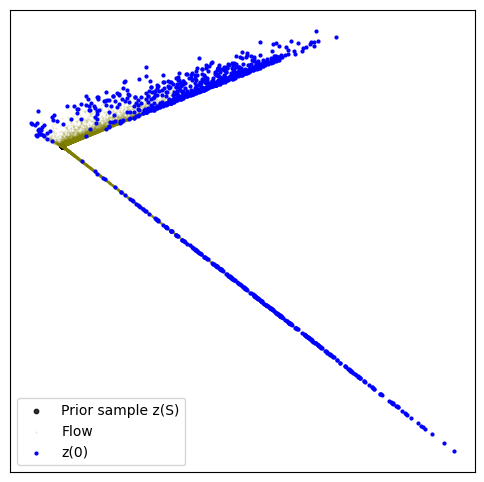

10200: loss -192.386 time 21.69 (avg: 0.108s/iter)


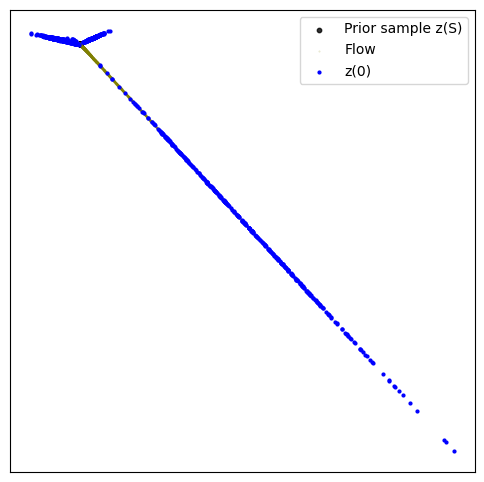

10400: loss -202.695 time 23.36 (avg: 0.117s/iter)


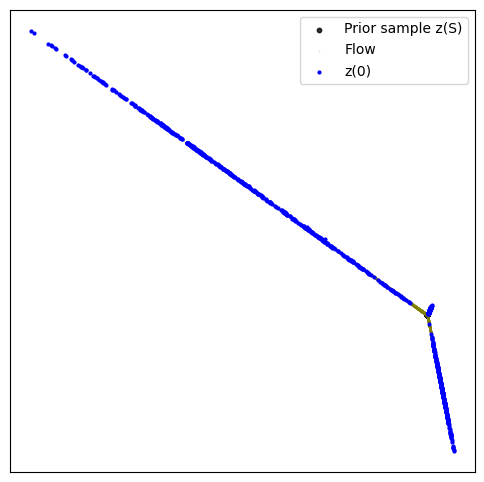

10600: loss -203.268 time 20.92 (avg: 0.105s/iter)


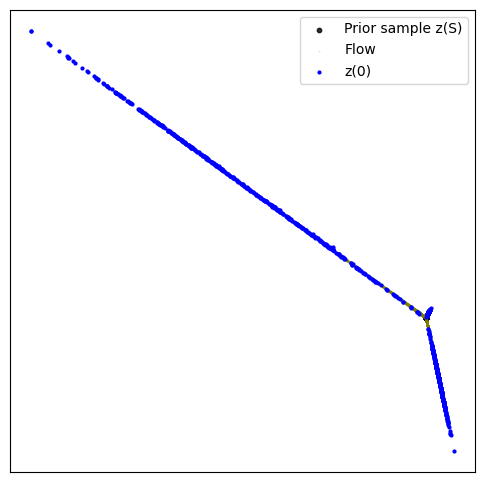

10800: loss -203.409 time 21.05 (avg: 0.105s/iter)


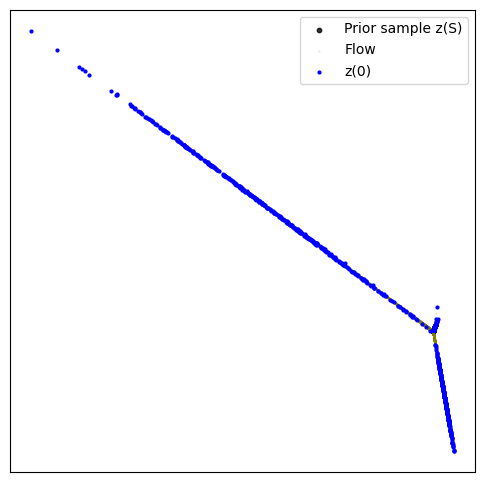

11000: loss -203.506 time 21.00 (avg: 0.105s/iter)


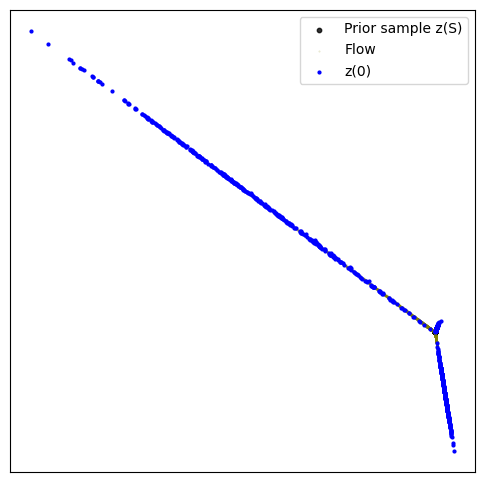

11200: loss -201.901 time 23.58 (avg: 0.118s/iter)


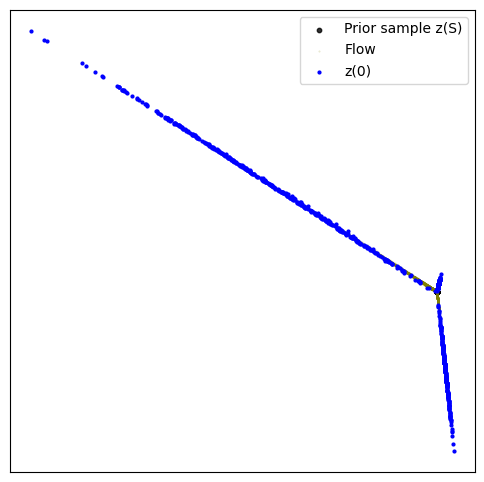

11400: loss -201.274 time 20.92 (avg: 0.105s/iter)


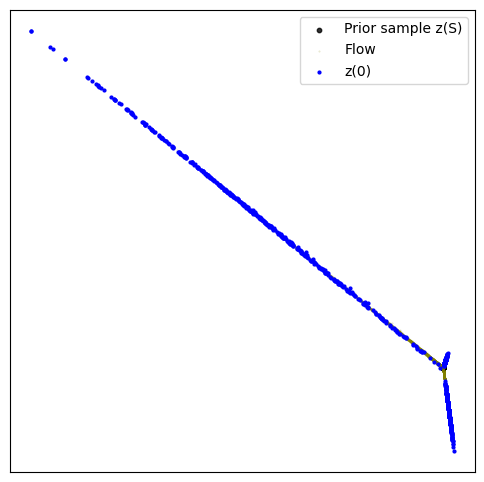

11600: loss -199.966 time 21.06 (avg: 0.105s/iter)


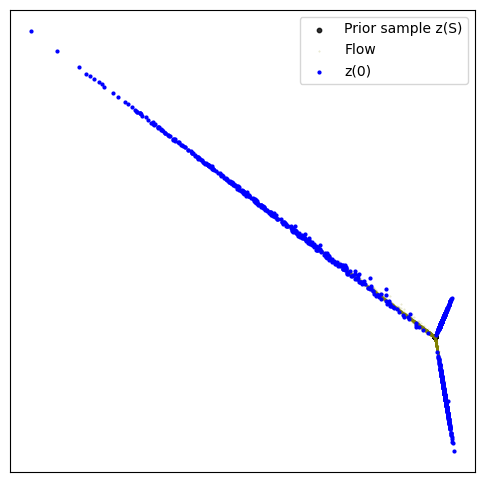

11800: loss -187.497 time 21.19 (avg: 0.106s/iter)


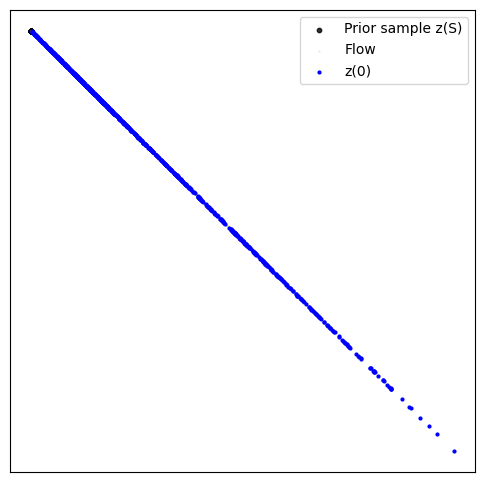

12000: loss -201.740 time 23.46 (avg: 0.117s/iter)


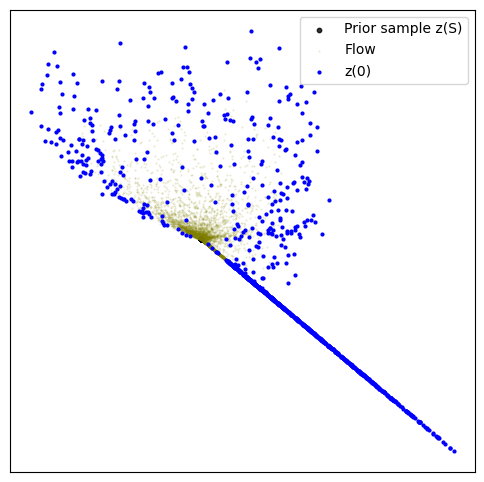

12200: loss -201.113 time 21.03 (avg: 0.105s/iter)


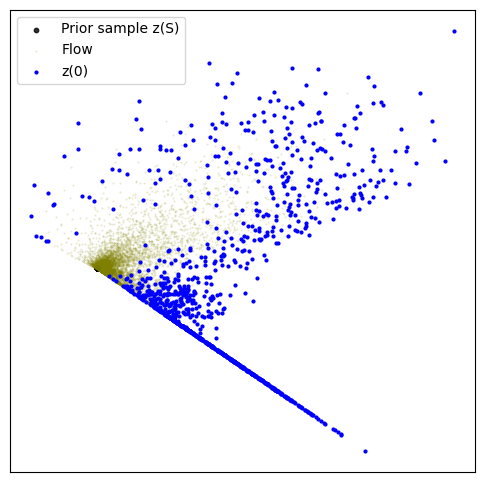

12400: loss -196.359 time 21.17 (avg: 0.106s/iter)


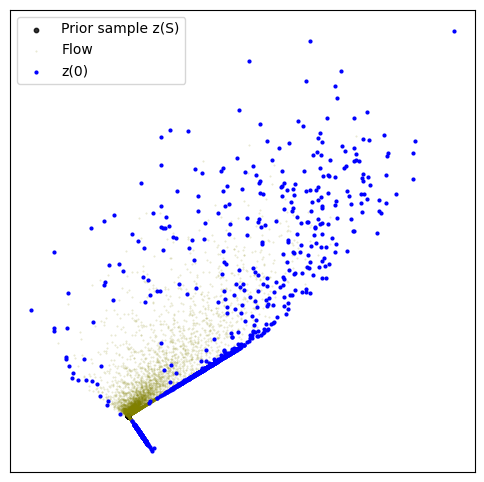

12600: loss -203.322 time 23.65 (avg: 0.118s/iter)


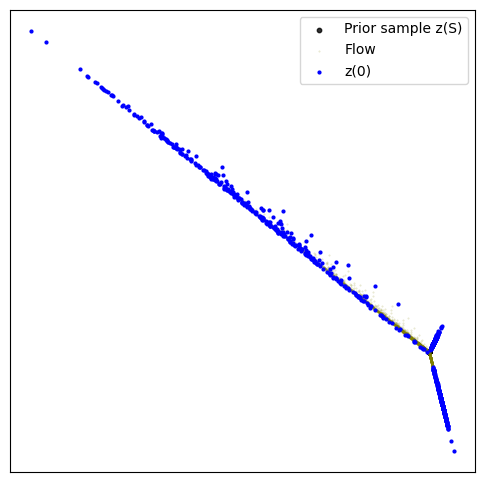

12800: loss -203.797 time 20.04 (avg: 0.100s/iter)


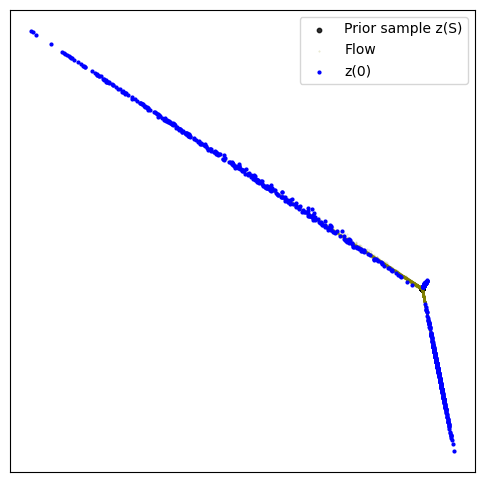

13000: loss -202.640 time 20.77 (avg: 0.104s/iter)


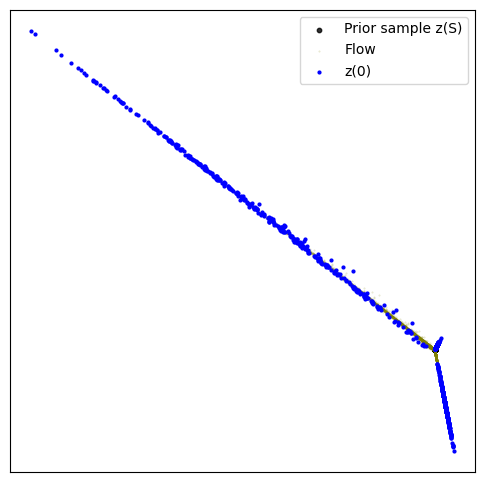

13200: loss -203.259 time 21.03 (avg: 0.105s/iter)


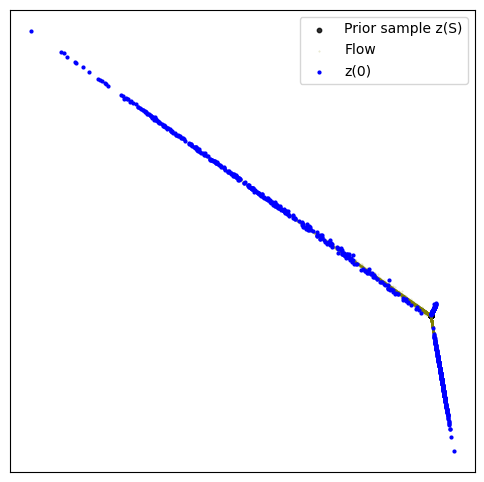

13400: loss -200.841 time 23.49 (avg: 0.117s/iter)


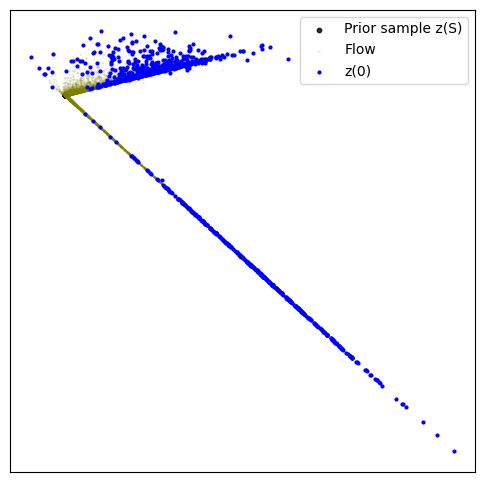

13600: loss -201.102 time 19.58 (avg: 0.098s/iter)


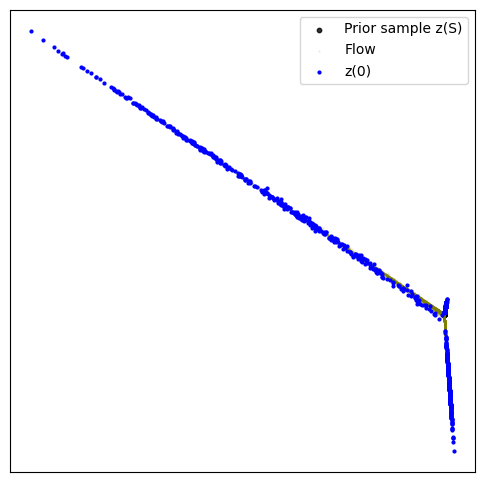

13800: loss -156.496 time 20.56 (avg: 0.103s/iter)


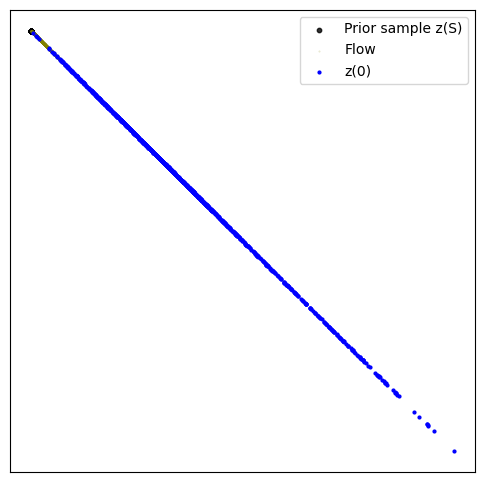

14000: loss -192.588 time 23.05 (avg: 0.115s/iter)


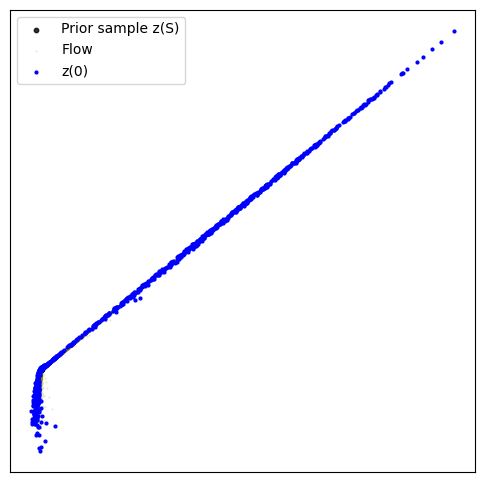

14200: loss -200.633 time 20.67 (avg: 0.103s/iter)


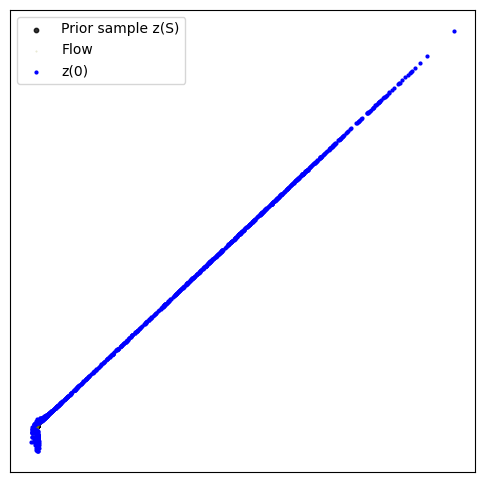

14400: loss -202.460 time 20.37 (avg: 0.102s/iter)


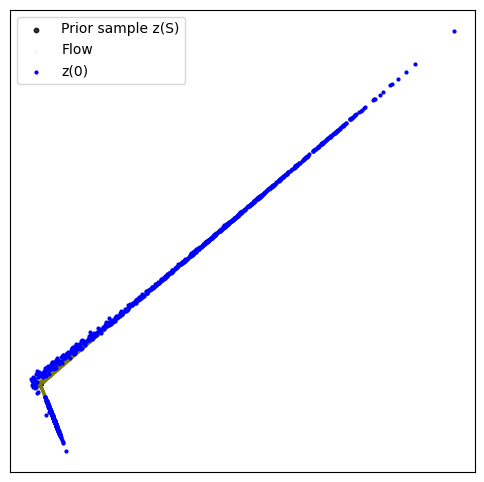

14600: loss -202.915 time 20.76 (avg: 0.104s/iter)


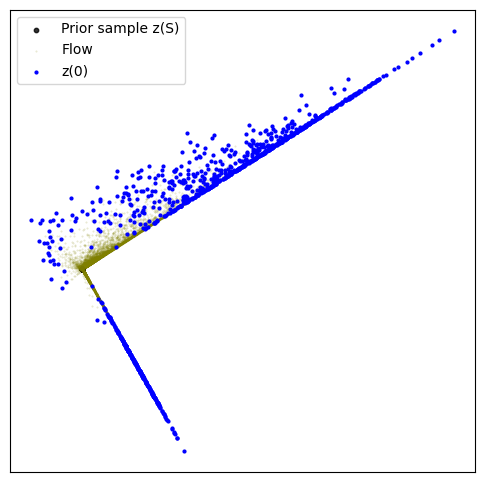

14800: loss -202.198 time 23.47 (avg: 0.117s/iter)


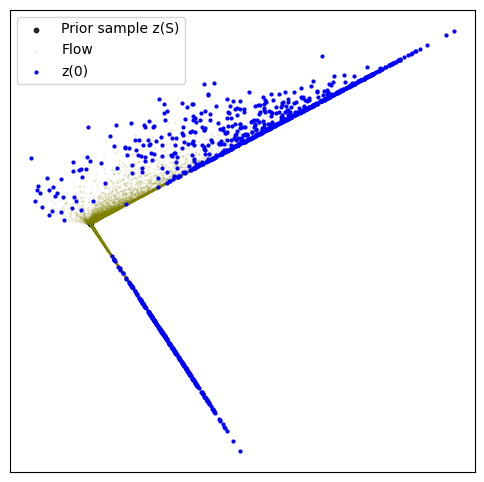

15000: loss -205.406 time 20.41 (avg: 0.102s/iter)


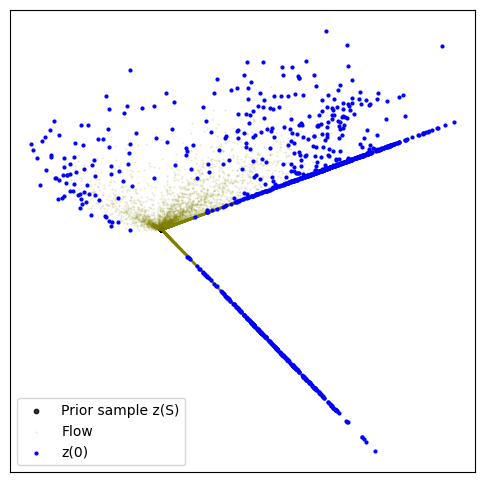

15200: loss -199.954 time 20.87 (avg: 0.104s/iter)


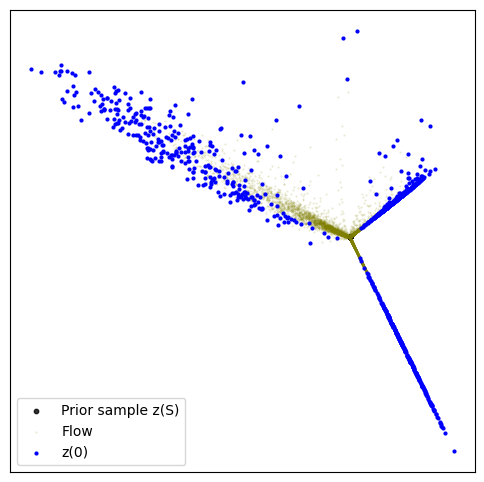

15400: loss -205.001 time 23.21 (avg: 0.116s/iter)


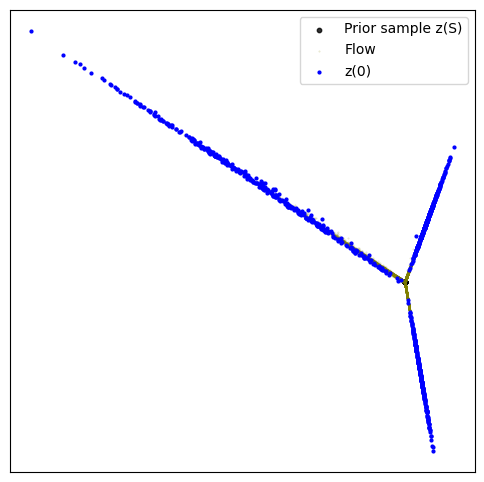

15600: loss -201.541 time 20.50 (avg: 0.103s/iter)


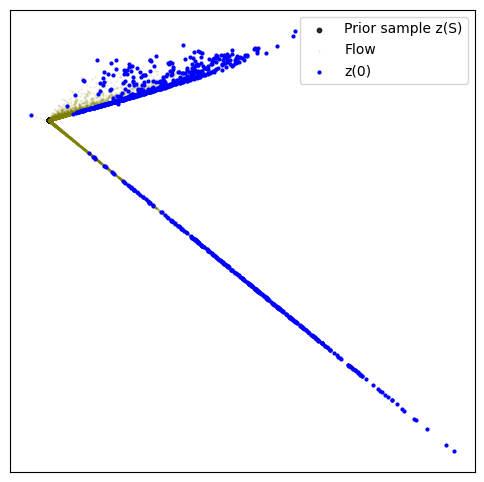

15800: loss -180.631 time 20.64 (avg: 0.103s/iter)


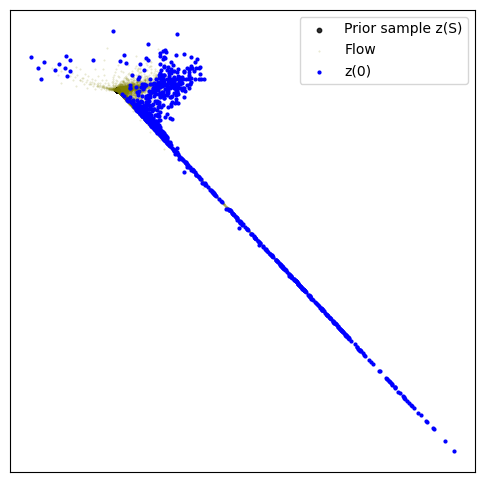

16000: loss -199.269 time 20.60 (avg: 0.103s/iter)


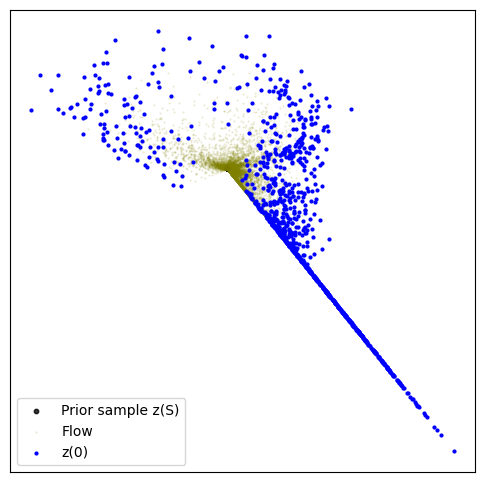

16200: loss -204.370 time 23.18 (avg: 0.116s/iter)


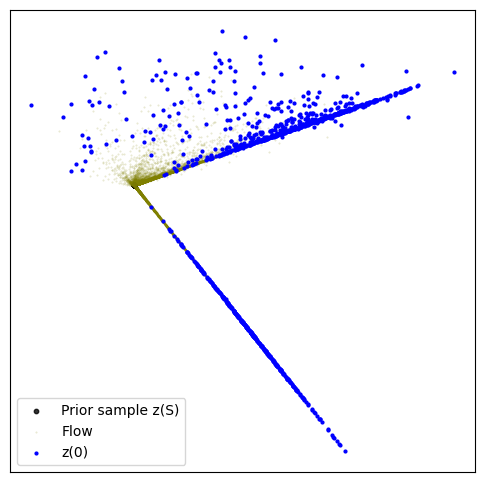

16400: loss -198.634 time 20.54 (avg: 0.103s/iter)


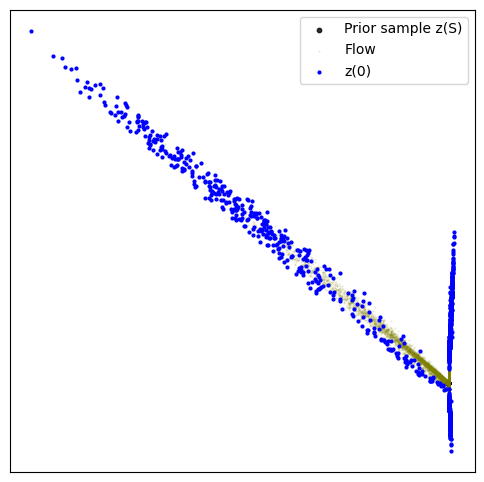

16600: loss -202.588 time 20.43 (avg: 0.102s/iter)


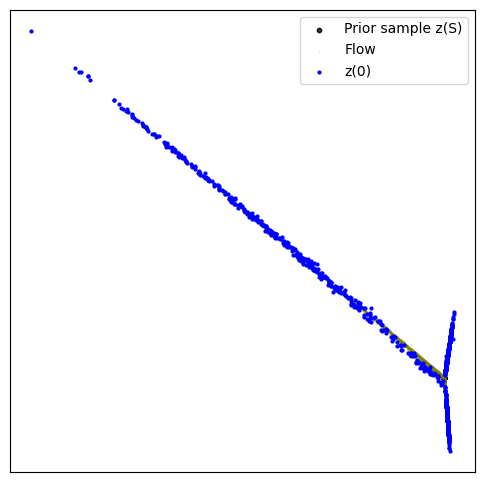

16800: loss -195.653 time 23.18 (avg: 0.116s/iter)


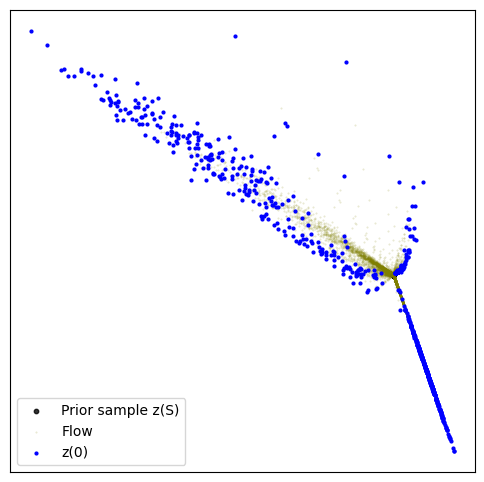

17000: loss -196.495 time 20.81 (avg: 0.104s/iter)


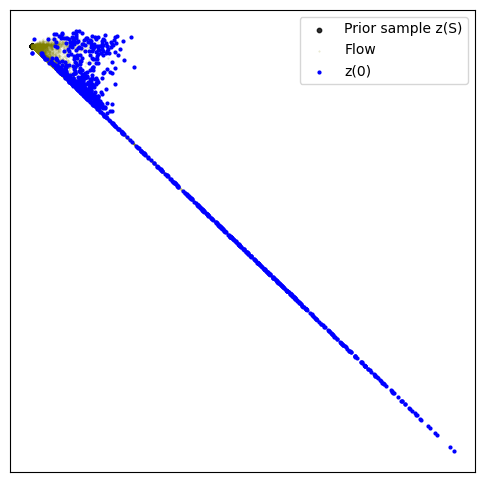

17200: loss -202.175 time 20.16 (avg: 0.101s/iter)


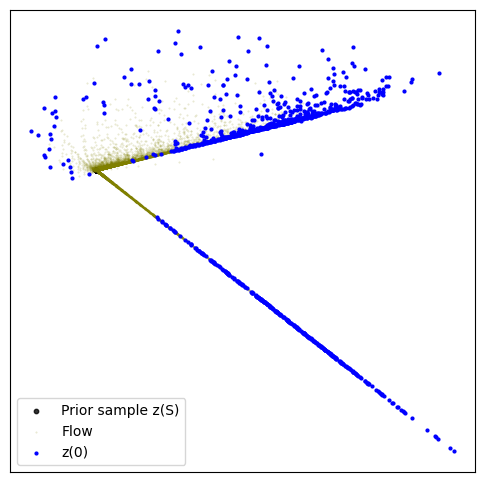

17400: loss -205.950 time 20.79 (avg: 0.104s/iter)


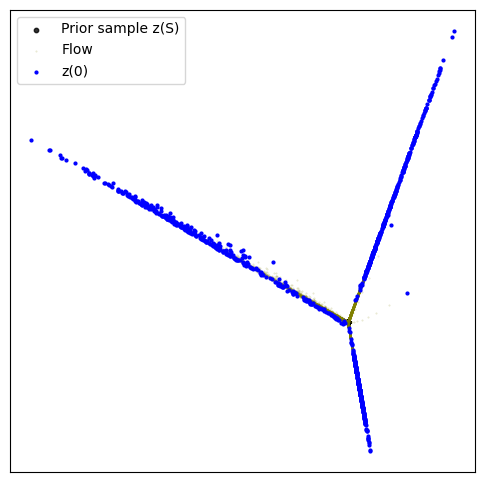

17600: loss -194.672 time 23.01 (avg: 0.115s/iter)


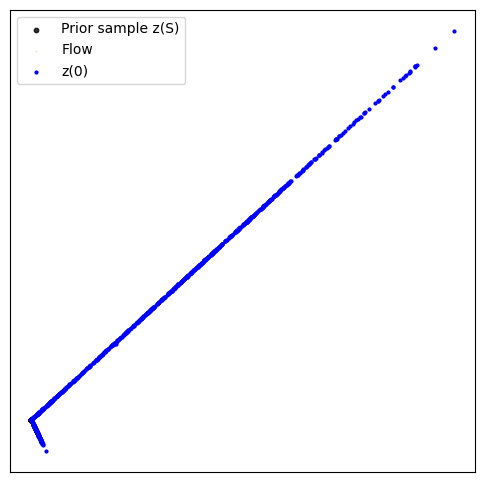

17800: loss -204.133 time 20.87 (avg: 0.104s/iter)


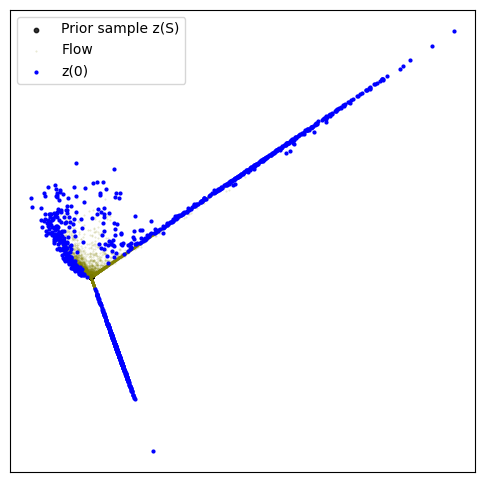

18000: loss -204.705 time 19.97 (avg: 0.100s/iter)


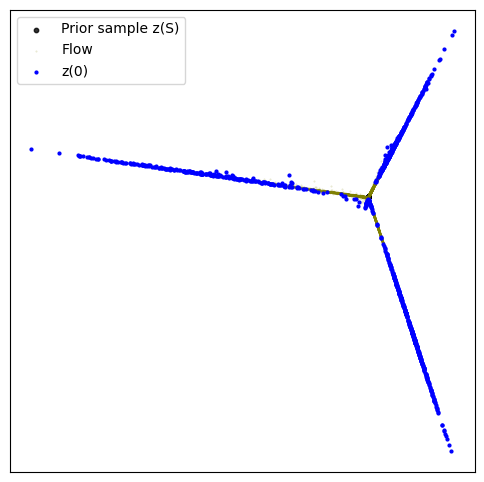

18200: loss -200.687 time 23.20 (avg: 0.116s/iter)


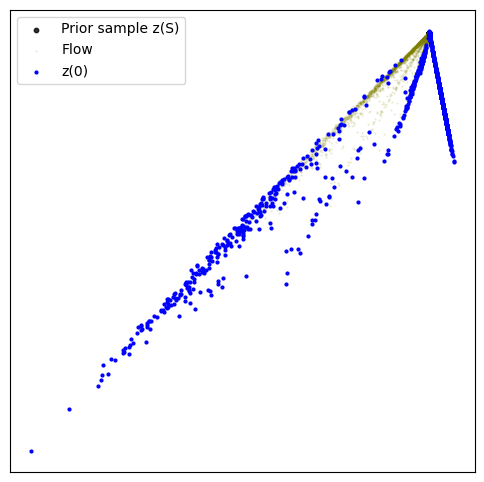

18400: loss -203.320 time 20.64 (avg: 0.103s/iter)


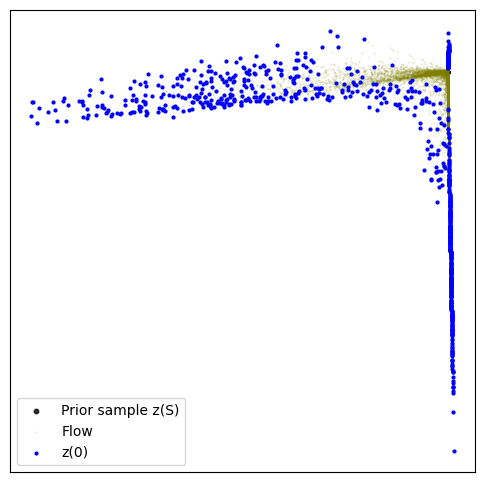

18600: loss -203.569 time 20.79 (avg: 0.104s/iter)


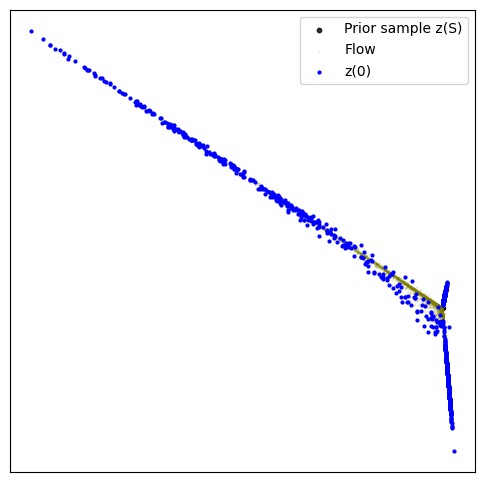

18800: loss -202.057 time 20.62 (avg: 0.103s/iter)


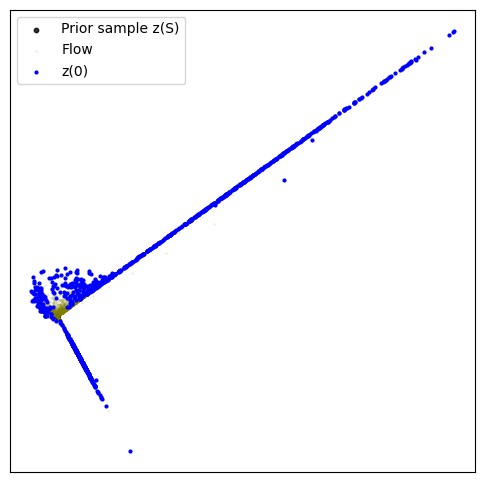

19000: loss -201.304 time 23.05 (avg: 0.115s/iter)


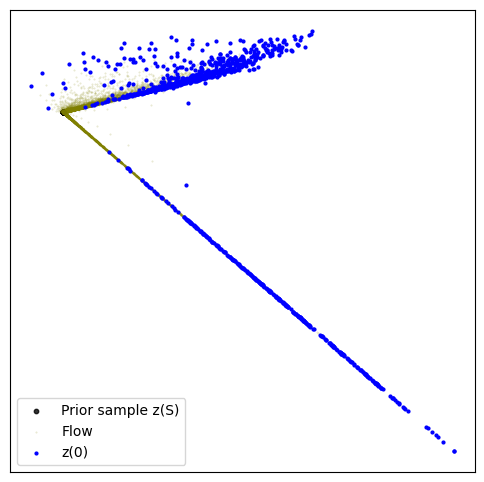

19200: loss -198.062 time 20.77 (avg: 0.104s/iter)


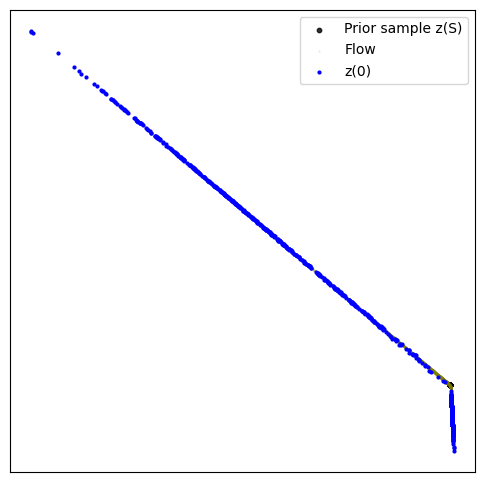

19400: loss -204.540 time 23.15 (avg: 0.116s/iter)


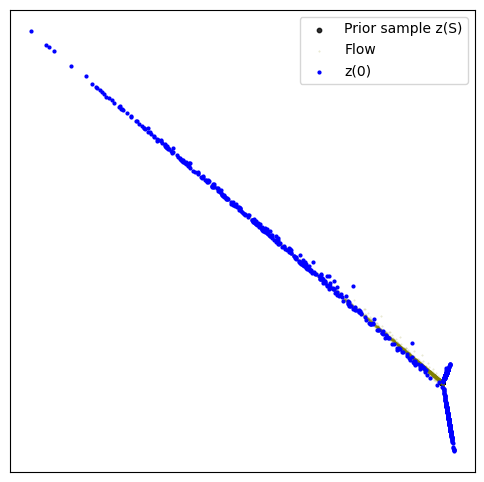

19600: loss -199.726 time 19.41 (avg: 0.097s/iter)


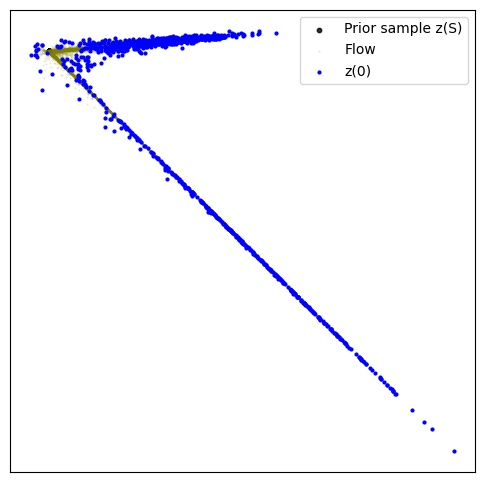

19800: loss -200.239 time 20.68 (avg: 0.103s/iter)


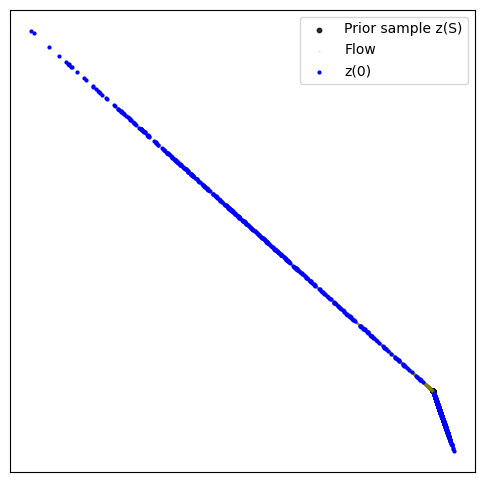

20000: loss -202.499 time 22.84 (avg: 0.114s/iter)


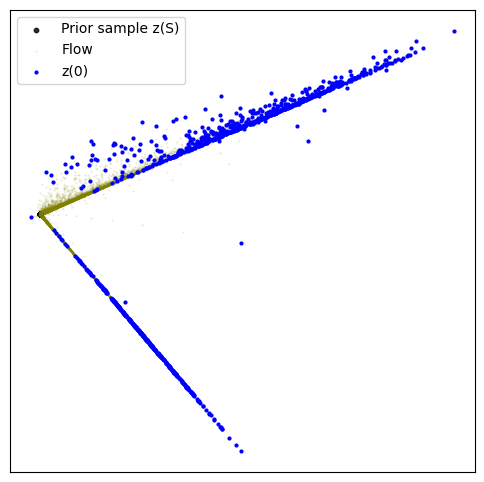

CPU times: user 28min 2s, sys: 8min 11s, total: 36min 13s
Wall time: 36min 6s


In [5]:
%%time
import optax

dim = 2
batch_size = 256
learning_rate = 1e-3
steps = 100

# Initialize model
key = random.PRNGKey(0)
model = MLP(dim=dim + 1, out_dim=dim, w=64, time_varying=False)  # +1 for time dimension
key, subkey = random.split(key)
dummy_input = jnp.ones((batch_size, dim + 1))
params = model.init(subkey, dummy_input)

# Initialize optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Prior distribution (multivariate normal)
prior_mean = jnp.zeros(dim)
prior_cov = jnp.eye(dim)

# Training step
@jax.jit
def train_step(params, opt_state, key):
    key, subkey1, subkey2 = random.split(key, 3)
    
    # Sample data
    x1 = sample_moons(batch_size)
    
    # Initialize with logp = 0
    x1_with_ll = jnp.concatenate([x1, jnp.zeros((batch_size, 1))], axis=-1)
    
    # Compute loss and gradients
    # Note: Maximum Likelihood CNF is inherently slow because it solves ODEs in the loss function
    # We optimize by: 1) reducing ODE steps, 2) using larger dt0, 3) JIT compiling the training step
    
    def make_vector_field(params):
        """Create a vector field function for the given params."""
        def vector_field_fn(t, y, args):
            cnf_wrapper_local = CNFWrapper(model, params, likelihood_estimator="exact")
            return cnf_wrapper_local.vector_field(t, y, args)
        return vector_field_fn
    
    def loss_fn(params):
        # Create vector field function
        vf = make_vector_field(params)
        
        # Create term - must be done inside to capture current params
        term = ODETerm(vf)
        
        solver = Euler()
        saveat = SaveAt(ts=jnp.linspace(1.0, 0.0, steps + 1))
        
        # Integrate backwards from t=1 to t=0 (use negative dt0 for backward integration)
        # Use larger dt0 for faster computation (less accurate but faster)
        solution = diffeqsolve(term, solver, t0=1.0, t1=0.0, dt0=-0.02, y0=x1_with_ll, 
                              saveat=saveat, args=subkey1)
        x0_with_ll = solution.ys[-1]
        
        # Compute log probability
        x0 = x0_with_ll[..., :-1]
        logp_flow = x0_with_ll[..., -1]
        logp_prior = multivariate_normal.logpdf(x0, prior_mean, prior_cov)
        logprob = logp_prior + logp_flow
        return -jnp.mean(logprob)
    
    # Compute loss and gradients
    # Note: We don't JIT this because ODETerm creation inside JIT can cause issues
    # The ODE solving is the bottleneck anyway, so JIT wouldn't help much here
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss, key

start = time.time()
print("Training Maximum Likelihood CNF...")
print("Note: This is slower than Flow Matching because it solves ODEs in the loss function.")
print("For faster training, consider using Flow Matching instead (see other notebooks).")
for k in range(20000):
    key, subkey = random.split(key)
    params, opt_state, loss, key = train_step(params, opt_state, subkey)
    
    if (k + 1) % 200 == 0:
        end = time.time()
        avg_time = (end - start) / 200
        print(f"{k+1}: loss {loss:.3f} time {(end - start):.2f} (avg: {avg_time:.3f}s/iter)")
        start = end
        
        # Generate trajectory for visualization
        key, subkey = random.split(key)
        x0_init = random.normal(subkey, (1024, dim))
        
        # Forward vector field (no logp tracking)
        def forward_vector_field(t, y, args):
            """Vector field for forward generation (no logp tracking)."""
            t_batch = jnp.full((y.shape[0],), t)
            model_input = jnp.concatenate([y, t_batch[:, None]], axis=-1)
            return model.apply(params, model_input)
        
        term = ODETerm(forward_vector_field)
        solver = Euler()
        saveat = SaveAt(ts=jnp.linspace(0.0, 1.0, steps + 1))
        solution = diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=0.01, y0=x0_init, saveat=saveat)
        traj = solution.ys  # Shape: (steps+1, 1024, dim)
        plot_trajectories(jnp.asarray(traj))


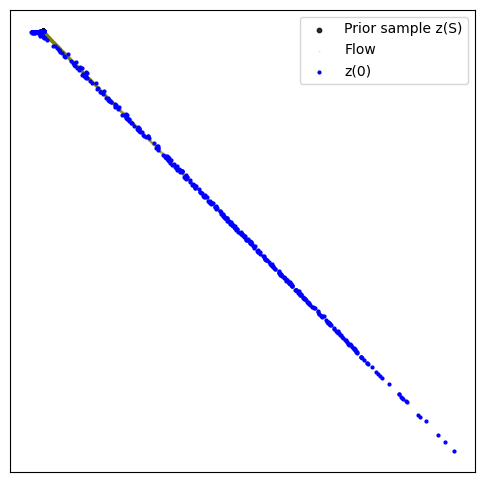

In [4]:
plot_trajectories(jnp.asarray(traj))